# Extended BUMP Analysis

## Preparation

#### Import dependencies

In [1]:
from collections import Counter
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import chi2_contingency

#### Configure plots look and feel

In [2]:
def set_plot_theme(base_font: int) -> None:
    """ 
    Set the theme for plots in the notebook."""
    sns.set_theme(
        style="whitegrid", 
        context="talk", 
        palette="colorblind",
        rc={
            "font.size": base_font, 
            "axes.titlesize": base_font + 4, 
            "axes.labelsize": base_font + 2,
            "xtick.labelsize": base_font,
            "ytick.labelsize": base_font,
            "legend.fontsize": base_font
            })
    
    mpl.rcParams.update({
        "figure.titlesize": base_font + 4,
        "axes.titlepad": 30,
        "axes.labelpad": 10
        })

set_plot_theme(10)

#### Read dataset

In [3]:
path = "data/bc_type_distribution_full_data.csv"
df = pd.read_csv(path)
df.head()

,BC_kinds,#files with this BC_kinds,BC_kinds_count,absolute_path_to_file_in_container,file_success,breakingCommit,model,build_success
0,NONE,107,0,/singer/singer-commons/src/main/java/com/pinte...,True,067f5d2c81ff87c90755f4ed48f62eb5faa8ecf9,gpt-5,True
1,NONE,107,0,/cyclonedx-maven-plugin/src/main/java/org/cycl...,True,1ee7d41d41fa991bbd52fc226a217de8fccf8e32,gpt-5,False
2,NONE,107,0,/cyclonedx-maven-plugin/src/main/java/org/cycl...,True,1ee7d41d41fa991bbd52fc226a217de8fccf8e32,gpt-5,False
3,NONE,107,0,/depclean/depclean-core/src/main/java/se/kth/d...,True,b86a5f84b44a9b50aee69745886c47123f721de3,gpt-5,False
4,NONE,107,0,/artifactory-plugin/src/main/java/org/jfrog/hu...,True,b5b64613a1a650a5784ff39386b4e00e05e5c21c,gpt-5,False


## Analysis

#### Compute number of files

In [4]:
files = len(df)
print(f"Total files: {files}")

Total files: 376


#### Identify breaking and non-breaking files

In [5]:
bc_files = df[df["BC_kinds"] != "NONE"]
bc_count = len(bc_files)

none_files = df[df["BC_kinds"] == "NONE"]
none_count = len(none_files)

print(f"Files with breaking changes: {bc_count} ({(bc_count / files) * 100:.2f}%)")
print(f"Files with no breaking changes: {none_count} ({(none_count / files) * 100:.2f}%)")

Files with breaking changes: 269 (71.54%)
Files with no breaking changes: 107 (28.46%)


#### Compute number of BC types per file

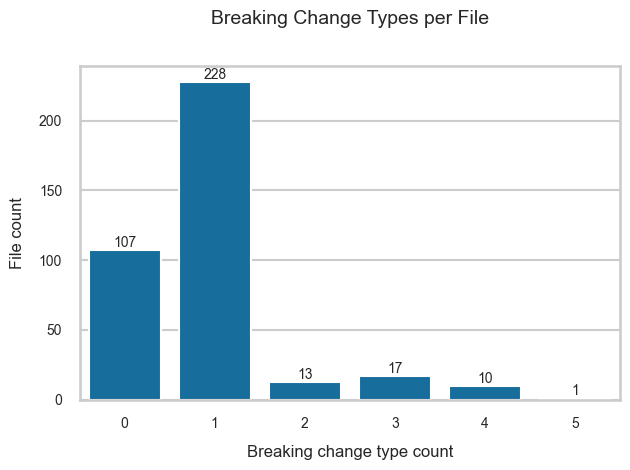

In [6]:
ax = sns.countplot(
    x="BC_kinds_count",
    data=df,
    order=sorted(df["BC_kinds_count"].unique())
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

ax.set_title("Breaking Change Types per File")
ax.set_xlabel("Breaking change type count")
ax.set_ylabel("File count")

plt.tight_layout()
plt.show()

In [7]:
def parse_bcs_labels(labels: str) -> list[str]:
    """
    Parses the breaking change labels from a string and returns a list 
    of breaking change types (e.g., METHOD_REMOVED, METHOD_ADDED_TO_INTERFACE,
    NONE). If the input is NaN or not a string, it returns an empty list.

    :param labels: A string containing the breaking change labels separated 
        by semicolons.
    :return: A list of breaking change types.
    """
    if not pd.isna(labels) and isinstance(labels, str):
        return [label.strip() for label in labels.split(";")]
    return []

In [8]:
df["bc_types"] = df["BC_kinds"].apply(parse_bcs_labels)
df.tail()

,BC_kinds,#files with this BC_kinds,BC_kinds_count,absolute_path_to_file_in_container,file_success,breakingCommit,model,build_success,bc_types
371,METHOD_ADDED_TO_INTERFACE; METHOD_REMOVED; SUP...,8,4,/jadler/jadler-jetty/src/main/java/net/jadler/...,True,95b2c15de16fd9fd612ce73672e29b613ce7a909,gpt-5,False,"[METHOD_ADDED_TO_INTERFACE, METHOD_REMOVED, SU..."
372,METHOD_ADDED_TO_INTERFACE; METHOD_REMOVED; SUP...,8,4,/jadler/jadler-jetty/src/main/java/net/jadler/...,True,5287fc631fa78e7f11d39983824cdd4215b9a03b,gpt-5,False,"[METHOD_ADDED_TO_INTERFACE, METHOD_REMOVED, SU..."
373,METHOD_ABSTRACT_ADDED_TO_CLASS; METHOD_ADDED_T...,1,4,/liquibase-mssql/src/java/liquibase/ext/mssql/...,True,feb582661e77de66eadaa7550720a8751b266ee4,gpt-5,False,"[METHOD_ABSTRACT_ADDED_TO_CLASS, METHOD_ADDED_..."
374,METHOD_ADDED_TO_INTERFACE; METHOD_REMOVED; MET...,1,4,/java-pubsub-group-kafka-connector/src/main/ja...,True,d54b56b91c11f21b97d4903143b04b7c1f10c255,gpt-5,False,"[METHOD_ADDED_TO_INTERFACE, METHOD_REMOVED, ME..."
375,METHOD_ADDED_TO_INTERFACE; METHOD_NOW_FINAL; M...,1,5,/bval/bval-jsr/src/test/java/org/apache/bval/j...,True,2dfaa41bfb97674d11f09a5885011f19808548a3,gpt-5,False,"[METHOD_ADDED_TO_INTERFACE, METHOD_NOW_FINAL, ..."


In [9]:
all_types = df["bc_types"].explode().tolist()
bc_type_counts = Counter(all_types)

bc_types_distribution = pd.DataFrame.from_dict(bc_type_counts, orient="index", columns=["count"])
bc_types_distribution["percentage"] = bc_types_distribution["count"] / files * 100
bc_types_distribution = bc_types_distribution.sort_values("count", ascending=False)

bc_types_distribution


,count,percentage
TYPE_REMOVED,195,51.861702
NONE,107,28.457447
METHOD_REMOVED,77,20.478723
METHOD_ADDED_TO_INTERFACE,21,5.585106
SUPERTYPE_REMOVED,14,3.723404
FIELD_REMOVED,13,3.457447
FIELD_TYPE_CHANGED,10,2.659574
METHOD_RETURN_TYPE_CHANGED,8,2.127660
METHOD_NO_LONGER_THROWS_CHECKED_EXCEPTION,3,0.797872
METHOD_NOW_FINAL,3,0.797872


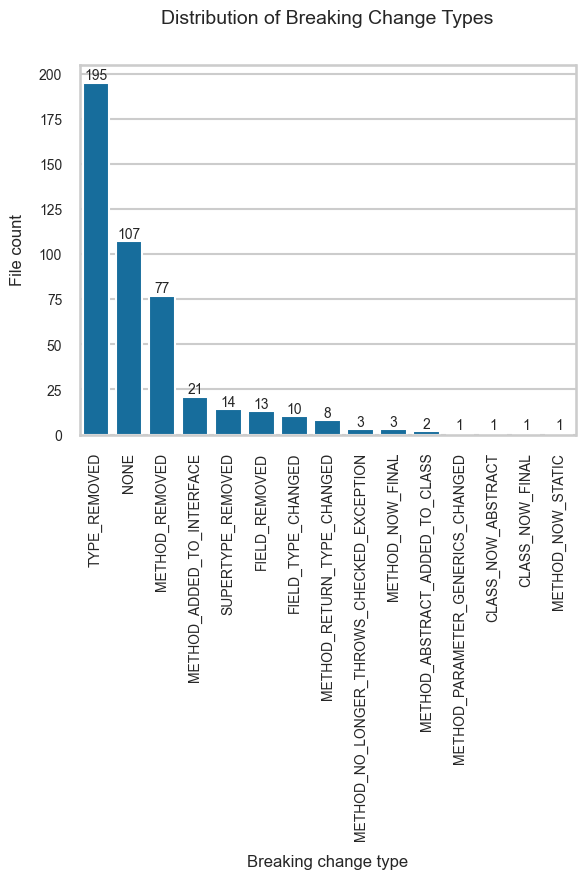

In [10]:
ax = sns.barplot(
    x=bc_types_distribution.index, 
    y=bc_types_distribution["count"]
)
plt.xticks(rotation=90)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

ax.set_title("Distribution of Breaking Change Types")
ax.set_xlabel("Breaking change type")
ax.set_ylabel("File count")

plt.show()

#### Remove files with NONE as BC

In [11]:
len_before = len(df)
df = df[df["BC_kinds"] != "NONE"]
len_after = len(df)
print(f"Removed {len_before - len_after} files with BC_kinds NONE. Remaining files: {len_after}")

Removed 107 files with BC_kinds NONE. Remaining files: 269


## Train/Test Split

**Current situation**
- Each file has more than one BC type, resulting in a multi-labeled dataset.
- We should prevent label imbalance when performing the split. This is more challenging given the multi-labeled nature of the dataset.
- We need to ensure we end up witha representative coverage of all BC types available in the dataset for bot the training and test datasets. 
- We do not cover all possible BC types due to the current dataset we count on. This should be reported in the threats to validity.

**Alternatives to perform the split**
- Random sampling with a final check would be possible if the dataset was not that small (as it is our case).
- Multi-label stratified split: guarantees that each split preserves the proportion of labels (aka. BC types) in the training and test datasets. We account for the multi-label nature of the dataset---a simple stratified split could fail.
- Multi-label stratified k-fold or cross-validation: prevents us from focusing on "too good" or "too bad" cases. Although ideal, it might become too computationally expensive.

#### Multi-label stratified split

In [12]:
binarizer = MultiLabelBinarizer()
Y = binarizer.fit_transform(df["bc_types"])

splitter = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

train_idx, test_idx = next(splitter.split(df, Y))

train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]
remaining_df = df.drop(test_df.index)

print(f"Size of training set: {len(train_df)} files")
print(f"Size of test set: {len(test_df)} files")

Size of training set: 214 files
Size of test set: 55 files


In [13]:
test_df.to_csv("data/test_set.csv", index=False)

#### Split the training dataset

In [14]:
def sample_training_set(base_df, size, seed=42):
    """
    Randomly samples a subset of the training data.
    
    :param base_df: The DataFrame to sample from.
    :param size: The number of samples to draw.
    :param seed: The random seed for reproducibility.
    :return: A DataFrame containing the sampled training data.
    """
    return base_df.sample(n=size, random_state=seed)

In [15]:
def label_distribution(df):
    """
    Computes the distribution of breaking change types in the given 
    DataFrame.
    
    :param df: The DataFrame containing a "bc_types" column with lists 
        of breaking change types.
    :return: A Counter object mapping each breaking change type to its count.
    """
    return Counter([l for labels in df["bc_types"] for l in labels])


def is_training_dataset_balanced(train_df, test_df, alpha=0.05):
    """
    Performs a chi-squared test to determine if the distribution of 
    breaking change types in the training set is statistically similar 
    to that in the test set.

    :param train_df: The training DataFrame.
    :param test_df: The test DataFrame.
    :param alpha: The significance level for the test (default is 0.05).
    :return: A tuple (is_balanced, p_value, chi2_statistic, cramers_v) where 
        is_balanced is True if the distributions are similar, False otherwise."""
    train_dist = label_distribution(train_df)
    test_dist = label_distribution(test_df)

    contingency = pd.DataFrame({
        "train": train_dist,
        "test": test_dist
    }).fillna(0)

    chi2, p_value, dof, expected = chi2_contingency(contingency)

    # Calculate Cramér's V (effect size)
    n = contingency.to_numpy().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))

    return p_value >= alpha, p_value, chi2, cramers_v

In [16]:
def create_training_datasets(rounds=5, remaining_df=remaining_df):
    """
    Creates multiple training datasets of increasing size and checks 
    if they are balanced with respect to the test set.
    
    :param rounds: The number of training datasets to create.
    :param remaining_df: The DataFrame to sample from for creating 
        training datasets.
    """
    total_train = len(remaining_df)
    samples_per_round = total_train // rounds
    _round = 0

    while _round < rounds:
        print(f"Creating training dataset for round {_round + 1} with {samples_per_round} samples...")
        train_df = sample_training_set(remaining_df, samples_per_round)
        is_balanced, p_value, chi2, cramers_v = is_training_dataset_balanced(train_df, test_df, alpha=0.01)
        
        if not is_balanced:
            print(f"Dataset for round {_round + 1} is imbalanced (p-value: {p_value:.4f}). Skipping this round.")
            continue

        train_df.to_csv(f"data/train_{samples_per_round}_round_{_round}.csv", index=False)
        _round += 1
        samples_per_round += total_train // rounds

        print(f"Chi-squared: {chi2:.4f}")
        print(f"P-value: {p_value:.4f}")
        print(f"Cramér's V: {cramers_v:.4f}")


In [17]:
create_training_datasets()

Creating training dataset for round 1 with 42 samples...
Chi-squared: 6.6092
P-value: 0.8298
Cramér's V: 0.2255
Creating training dataset for round 2 with 84 samples...
Chi-squared: 4.7781
P-value: 0.9414
Cramér's V: 0.1648
Creating training dataset for round 3 with 126 samples...
Chi-squared: 5.1257
P-value: 0.9536
Cramér's V: 0.1496
Creating training dataset for round 4 with 168 samples...
Chi-squared: 4.5783
P-value: 0.9706
Cramér's V: 0.1272
Creating training dataset for round 5 with 210 samples...
Chi-squared: 2.3790
P-value: 0.9994
Cramér's V: 0.0829


#### BC-based training dataset

In [18]:
def create_training_datasets_per_bc_type(remaining_df=remaining_df, test_df=test_df, min_samples_per_type=40):
    """
    Creates training datasets where each round focuses on files containing 
    a specific breaking change type. For each BC type found in the remaining_df,
    it creates a training dataset containing only files with that label.
    
    :param remaining_df: The DataFrame to sample from for creating training datasets.
    :param test_df: The test DataFrame (used for reference).
    :param min_samples_per_type: Minimum number of samples required for a BC type to 
        be included.
    """
    bc_types = {bc_type for bc_types in remaining_df["bc_types"] for bc_type in bc_types}
    bc_types = sorted(bc_types)
    
    for _round, bc_type in enumerate(bc_types):
        train_df = remaining_df[remaining_df["bc_types"].apply(lambda x: bc_type in x)]
        
        if len(train_df) < min_samples_per_type:
            print(f"Skipping BC type '{bc_type}', only {len(train_df)} samples found")
            continue
        
        print(f"Creating training dataset for round {_round + 1} with {len(train_df)} samples...")
        train_df.to_csv(f"data/train_{bc_type}.csv", index=False)


In [19]:
create_training_datasets_per_bc_type()

Skipping BC type 'CLASS_NOW_ABSTRACT', only 1 samples found
Skipping BC type 'CLASS_NOW_FINAL', only 1 samples found
Skipping BC type 'FIELD_REMOVED', only 10 samples found
Skipping BC type 'FIELD_TYPE_CHANGED', only 8 samples found
Skipping BC type 'METHOD_ABSTRACT_ADDED_TO_CLASS', only 2 samples found
Skipping BC type 'METHOD_ADDED_TO_INTERFACE', only 17 samples found
Skipping BC type 'METHOD_NOW_FINAL', only 2 samples found
Skipping BC type 'METHOD_NOW_STATIC', only 1 samples found
Skipping BC type 'METHOD_NO_LONGER_THROWS_CHECKED_EXCEPTION', only 2 samples found
Skipping BC type 'METHOD_PARAMETER_GENERICS_CHANGED', only 1 samples found
Creating training dataset for round 11 with 62 samples...
Skipping BC type 'METHOD_RETURN_TYPE_CHANGED', only 6 samples found
Skipping BC type 'SUPERTYPE_REMOVED', only 11 samples found
Creating training dataset for round 14 with 156 samples...


## \<EOF\>